In [1]:
import pytorch_lightning as pl
import torch
import transformers
from PIL import Image
import random
import pandas as pd

In [2]:
from model.visual_text_encoder_decoder import VisualTextEncoderDecoder

In [3]:
from transformers import AutoTokenizer, AutoFeatureExtractor
import matplotlib.pyplot as plt

In [4]:
df = pd.read_json('/data/clean_raw_text/all_data_cleaned_only_wk_refine.json', lines=True)

In [5]:
df.src.unique()

array(['wukong'], dtype=object)

In [6]:
# df = df[df.src.eq('非12345多模态')]

In [7]:
tokenizer = AutoTokenizer.from_pretrained('hfl/chinese-roberta-wwm-ext', cache_dir='/data/.cache')

In [8]:
model = VisualTextEncoderDecoder.load_from_checkpoint('/data/proj/pretrain_image2text/pl_log/image2text_ft/3b0qft17/checkpoints/last.ckpt', tokenizer=tokenizer, device='cuda:7', strict=False)

freeze visual_encoder.embeddings.cls_token
freeze visual_encoder.embeddings.position_embeddings
freeze visual_encoder.embeddings.patch_embeddings.projection.weight
freeze visual_encoder.embeddings.patch_embeddings.projection.bias
freeze visual_encoder.encoder.layer.0.attention.attention.query.weight
freeze visual_encoder.encoder.layer.0.attention.attention.query.bias
freeze visual_encoder.encoder.layer.0.attention.attention.key.weight
freeze visual_encoder.encoder.layer.0.attention.attention.key.bias
freeze visual_encoder.encoder.layer.0.attention.attention.value.weight
freeze visual_encoder.encoder.layer.0.attention.attention.value.bias
freeze visual_encoder.encoder.layer.0.attention.output.dense.weight
freeze visual_encoder.encoder.layer.0.attention.output.dense.bias
freeze visual_encoder.encoder.layer.0.intermediate.dense.weight
freeze visual_encoder.encoder.layer.0.intermediate.dense.bias
freeze visual_encoder.encoder.layer.0.output.dense.weight
freeze visual_encoder.encoder.layer.

In [9]:
visual_encoder_decoder = model.model

In [10]:
processor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k", cache_dir='/data/.cache')

In [11]:
def preprocess_image(image_path: str) -> torch.Tensor:
    image = Image.open(image_path)
    inputs = processor(image)
    return inputs.pixel_values, image

In [12]:
from pathlib import Path

non_12345_dir = list(Path('/data/clean_raw_text/data/wukong/refine_images').glob('*'))

In [13]:
# for n, p in visual_encoder_decoder.named_parameters():
#     if not n.startswith('encoder.'):
#         p.requires_grad = False
#         print('freeze {}'.format(n))

In [14]:
visual_encoder_decoder.eval()

VisualEncoderLMDecoder(
  (visual_encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768,

In [15]:
model = model.to('cuda:7')

In [95]:
pixels, image = preprocess_image(random.choice(non_12345_dir))
pixels = torch.tensor(pixels[0]).unsqueeze(0).to(model.device)

['[CLS] 我 为 群 众 办 实 事 罗 定 市 罗 岗 镇 中 心 小 学 开 展 2021 年 春 季 开 学 工 作 以 来 ， 全 体 师 生 共 克 时 艰 ， 克 服 严 重 困 难 ， 在 全 力 以 赴 完 成 疫 情 防 控 的 新 一 轮 课 后 托 管 服 务 任 务 ， 按 照 区 教 育 局 统 一 部 署 和 要 求 和 时 间 节 点 安 排 ， 为 了 确 保 学 生 放 假 期 间 学 校 正 常 上 课 安 全 。 [SEP]']


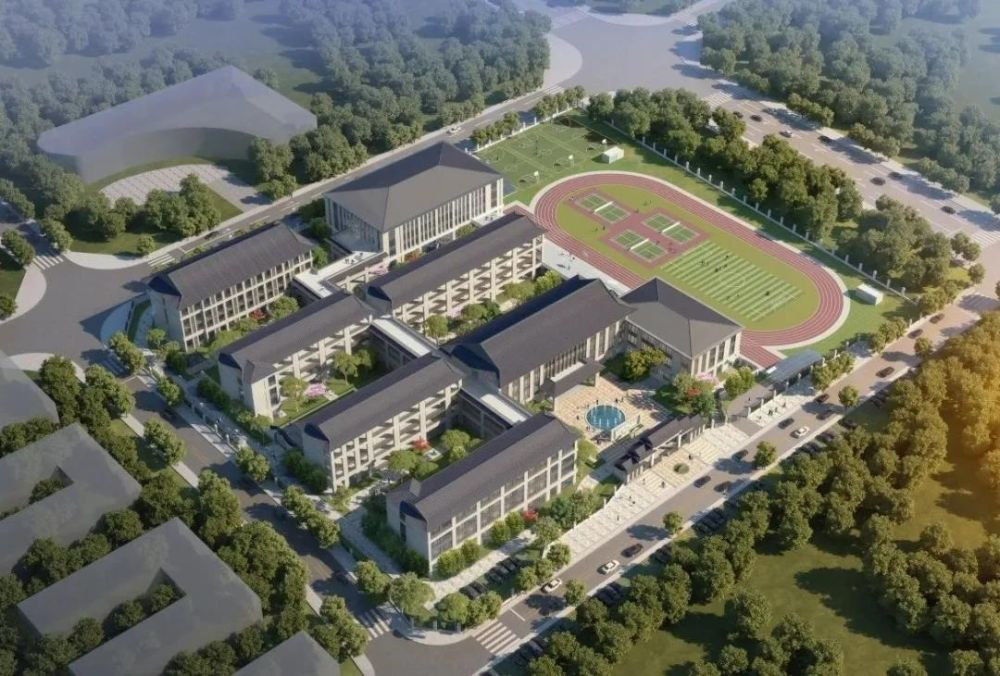

: 

In [96]:
# output_ids = visual_encoder_decoder.generate(pixels, num_beams=3, max_length=128, min_length=5, no_repeat_ngram_size=1, early_stopping=False, length_penalty=1.2, remove_invalid_values=True)
output_ids = visual_encoder_decoder.generate(pixels, do_sample=True, top_k=0, top_p=0.9, max_length=256, min_length=5, no_repeat_ngram_size=2, length_penalty=1.2, remove_invalid_values=True)
preds = tokenizer.batch_decode(output_ids, skip_special_tokens=False)
print(preds)
image.show()